In [1]:
#importing library
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
#Load the data 
movies=pd.read_csv('tmdb_5000_movies.csv')
credits=pd.read_csv('tmdb_5000_credits.csv')

c:\Users\salvarezvaldivia\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242

In [3]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",12/10/2009,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",5/19/2007,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",10/26/2015,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",7/16/2012,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",3/7/2012,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
C= movies['vote_average'].mean()
C

6.092171559442016

In [5]:
m= movies['vote_count'].quantile(0.9)
m

1838.4000000000015

In [17]:
# Filter based on popularity
movies = movies[movies['vote_average'] >= 8]

## Data Visualizations

Text(0.5, 1.0, 'Popular Movies')

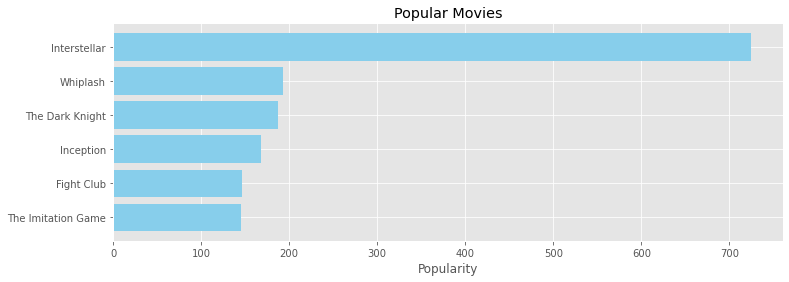

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#popularMovies['year'] = popularMovies['release_date'][-4:]
#grouped_by_year = popularMovies.groupby('year').mean()
#popularMovies

pop= movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Text(0.5, 1.0, 'Best Rated Movies')

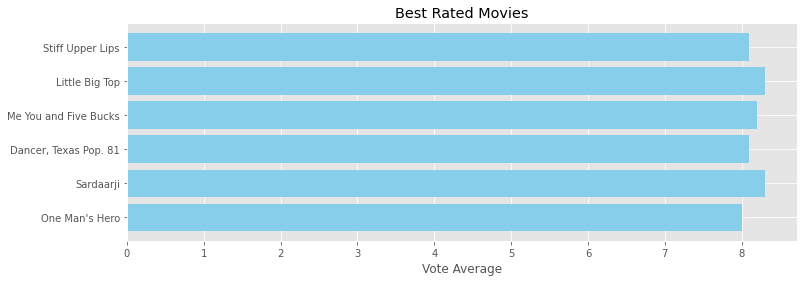

In [19]:
best_rated = movies.sort_values('vote_average', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(best_rated['title'].head(6),pop['vote_average'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Vote Average")
plt.title("Best Rated Movies")

Text(0.5, 1.0, 'Most Rated Movies')

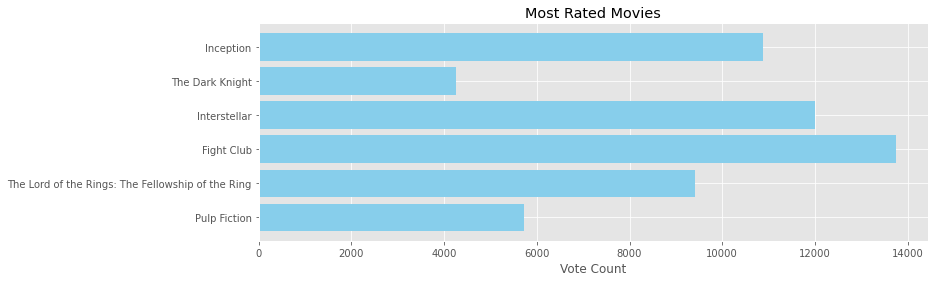

In [20]:
most_voted = movies.sort_values('vote_count', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(most_voted['title'].head(6),pop['vote_count'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Vote Count")
plt.title("Most Rated Movies")

In [21]:
# Create year column
movies['year'] = movies['release_date'].str[-4:]
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year
65,185000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",http://thedarkknight.warnerbros.com/dvdsite/,155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,7/16/2008,1004558444,152.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Why So Serious?,The Dark Knight,8.2,12002,2008
77,175000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",http://movies.disney.com/inside-out,150540,"[{""id"": 1566, ""name"": ""dream""}, {""id"": 6513, ""...",en,Inside Out,"Growing up can be a bumpy road, and it's no ex...",128.655964,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,6/9/2015,857611174,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Meet the little voices inside your head.,Inside Out,8.0,6560,2015
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,157336,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",...,11/5/2014,675120017,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mankind was born on Earth. It was never meant ...,Interstellar,8.1,10867,2014
96,160000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://inceptionmovie.warnerbros.com/,27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,7/14/2010,825532764,148.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Your mind is the scene of the crime.,Inception,8.1,13752,2010
262,93000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://www.lordoftherings.net/,120,"[{""id"": 603, ""name"": ""elves""}, {""id"": 604, ""na...",en,The Lord of the Rings: The Fellowship of the Ring,"Young hobbit Frodo Baggins, after inheriting a...",138.049577,"[{""name"": ""WingNut Films"", ""id"": 11}, {""name"":...",...,12/18/2001,871368364,178.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,One ring to rule them all,The Lord of the Rings: The Fellowship of the Ring,8.0,8705,2001


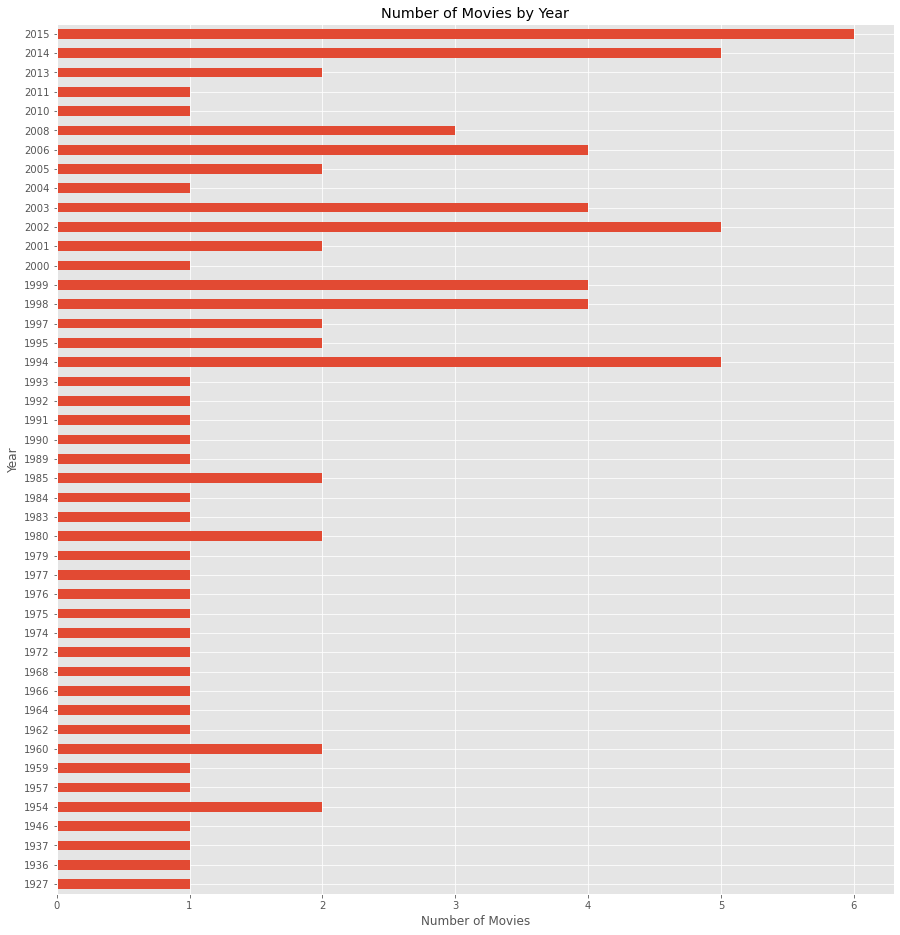

In [22]:
movies.year.value_counts(dropna=True).sort_index().plot(kind='barh',figsize=(15,16))
plt.title('Number of Movies by Year')
plt.xlabel('Number of Movies')
plt.ylabel('Year')
plt.show()

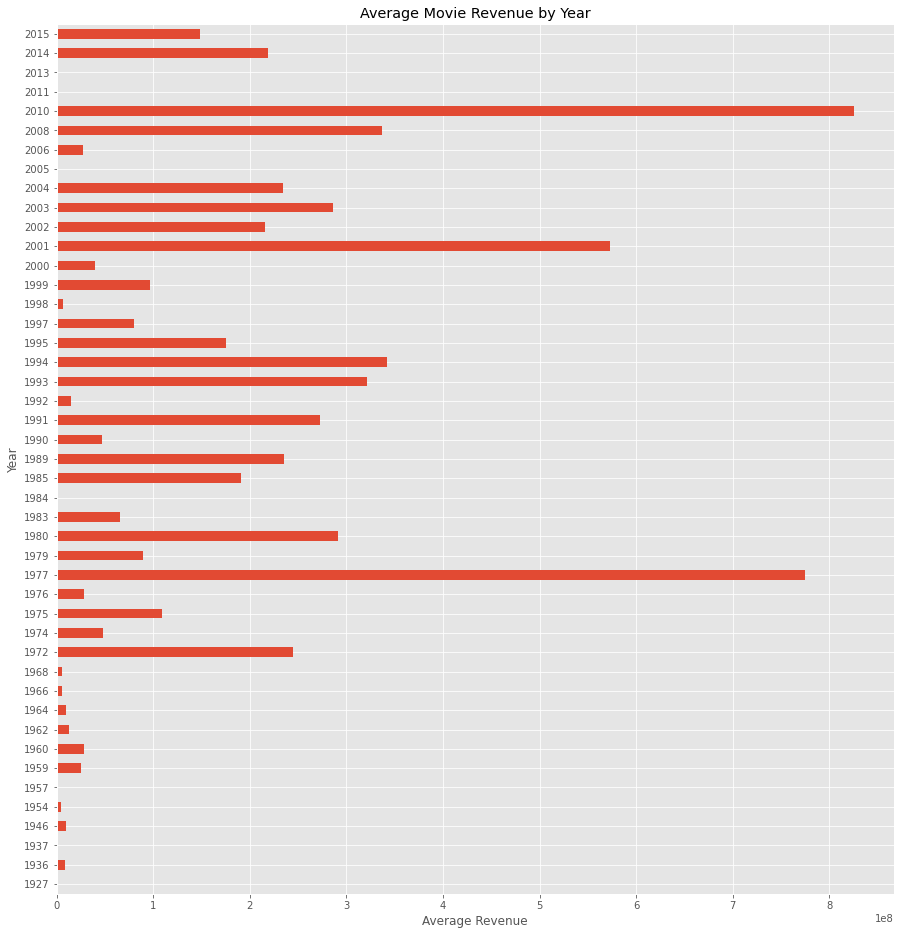

In [23]:
movies.groupby('year')['revenue'].mean().plot(kind='barh',figsize=(15,16))
plt.title('Average Movie Revenue by Year')
plt.xlabel('Average Revenue')
plt.ylabel('Year')
plt.show()

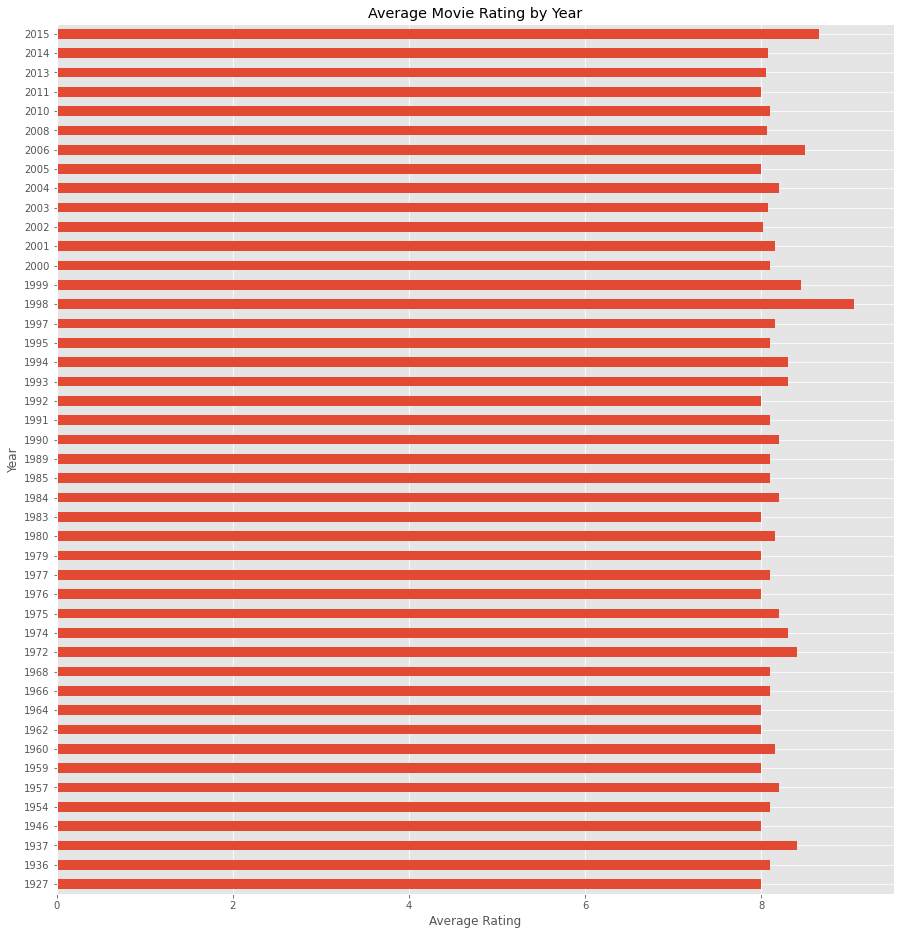

In [24]:
movies.groupby('year')['vote_average'].mean().plot(kind='barh',figsize=(15,16))
plt.title('Average Movie Rating by Year')
plt.xlabel('Average Rating')
plt.ylabel('Year')
plt.show()

In [25]:
def weighted_rating(x, movies=movies, credits=credits):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [9]:
credits.head()

,movie_id,title,cast,crew,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 1255,Unnamed: 1256,Unnamed: 1257,Unnamed: 1258,Unnamed: 1259,Unnamed: 1260,Unnamed: 1261,Unnamed: 1262,Unnamed: 1263,Unnamed: 1264
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#check the shape of the two dataset 
print("movies dataset shape: ",movies.shape)
print("credits dataset shape: ",credits.shape)

movies dataset shape:  (4803, 20)
credits dataset shape:  (4813, 1265)


In [11]:
# merge the two dataset into one dataset
movies=movies.merge(credits,on="title")
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,Unnamed: 1255,Unnamed: 1256,Unnamed: 1257,Unnamed: 1258,Unnamed: 1259,Unnamed: 1260,Unnamed: 1261,Unnamed: 1262,Unnamed: 1263,Unnamed: 1264
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# removing the unwanted columns 
movies=movies[["movie_id","title","overview","genres","keywords","cast","crew"]]

In [13]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4809 non-null   object
 1   title     4809 non-null   object
 2   overview  4806 non-null   object
 3   genres    4809 non-null   object
 4   keywords  4809 non-null   object
 5   cast      4809 non-null   object
 6   crew      4805 non-null   object
dtypes: object(7)
memory usage: 300.6+ KB


In [15]:
#chacking the missing data
movies.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        4
dtype: int64

In [16]:
#removing the missing data
movies.dropna(inplace=True)

# Preprocessing and formating some columns


In [17]:
#genres col 
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

this format is seems to be wrong ,we can fixed it -----we convert the '[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]' format into the ["Action","Adventure","Fantasy","Science Fiction"] format....



In [18]:
def convert(obj):
    l=[]
    for i in ast.literal_eval(obj):
        l.append(i["name"])
    return l     

In [19]:
movies["genres"]=movies["genres"].apply(convert)

In [20]:
movies["genres"].head()

0    [Action, Adventure, Fantasy, Science Fiction]
1                     [Adventure, Fantasy, Action]
2                       [Action, Adventure, Crime]
3                 [Action, Crime, Drama, Thriller]
4             [Action, Adventure, Science Fiction]
Name: genres, dtype: object

In [21]:
#keyword columns 
movies["keywords"].head()

0    [{"id": 1463, "name": "culture clash"}, {"id":...
1    [{"id": 270, "name": "ocean"}, {"id": 726, "na...
2    [{"id": 470, "name": "spy"}, {"id": 818, "name...
3    [{"id": 849, "name": "dc comics"}, {"id": 853,...
4    [{"id": 818, "name": "based on novel"}, {"id":...
Name: keywords, dtype: object

In [22]:
#convert into correct format
movies["keywords"]=movies["keywords"].apply(convert)
movies["keywords"].head()

0    [culture clash, future, space war, space colon...
1    [ocean, drug abuse, exotic island, east india ...
2    [spy, based on novel, secret agent, sequel, mi...
3    [dc comics, crime fighter, terrorist, secret i...
4    [based on novel, mars, medallion, space travel...
Name: keywords, dtype: object

In [23]:
#cast columns 
movies["cast"][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

Here in cast column we only need the first 3 dictionary which contain the main 3 acctrees name and from the 3 dict we only need the name of the acctrees ,lets so it ..


In [24]:
def convert3(obj):
    l=[]
    counter=0
    for i in ast.literal_eval(obj):
        if counter !=3:
            l.append(i["name"])
            counter+=1
        else:
            break
    return l     

In [25]:
movies["cast"]=movies["cast"].apply(convert3)
movies["cast"]

0        [Sam Worthington, Zoe Saldana, Sigourney Weaver]
1           [Johnny Depp, Orlando Bloom, Keira Knightley]
2            [Daniel Craig, Christoph Waltz, Léa Seydoux]
3            [Christian Bale, Michael Caine, Gary Oldman]
4          [Taylor Kitsch, Lynn Collins, Samantha Morton]
                              ...                        
4804    [Carlos Gallardo, Jaime de Hoyos, Peter Marqua...
4805         [Edward Burns, Kerry Bishé, Marsha Dietlein]
4806           [Eric Mabius, Kristin Booth, Crystal Lowe]
4807            [Daniel Henney, Eliza Coupe, Bill Paxton]
4808    [Drew Barrymore, Brian Herzlinger, Corey Feldman]
Name: cast, Length: 4802, dtype: object

In [26]:
#crew column 
movies["crew"][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

Here we only need the director name for each dict....lets go

In [93]:
def featch_dir(obj): 
    l=[]
    for i in ast.literal_eval(obj):
        if i["job"]=="Director":
            l.append(i["name"])
            break
    return l 

In [94]:
movies["crew"]=movies["crew"].apply(featch_dir)
movies["crew"]

SyntaxError: unterminated string literal (detected at line 1) (<unknown>, line 1)

In [95]:
# we have a problem in overview col that is,our overview col are string but we need this col as a list of list .
movies["overview"][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [96]:
#let convert it
movies["overview"]=movies["overview"].apply(lambda x:x.split())
movies["overview"]

0       [In, the, 22nd, century,, a, paraplegic, Marin...
1       [Captain, Barbossa,, long, believed, to, be, d...
2       [A, cryptic, message, from, Bond’s, past, send...
3       [Following, the, death, of, District, Attorney...
4       [John, Carter, is, a, war-weary,, former, mili...
                              ...                        
4804    [El, Mariachi, just, wants, to, play, his, gui...
4805    [A, newlywed, couple's, honeymoon, is, upended...
4806    ["Signed,, Sealed,, Delivered", introduces, a,...
4807    [When, ambitious, New, York, attorney, Sam, is...
4808    [Ever, since, the, second, grade, when, he, fi...
Name: overview, Length: 4802, dtype: object

In [97]:
#finally our dataset look like this
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [98]:
#removing the space from all the columns values.
movies["genres"]=movies["genres"].apply(lambda x:[i.replace(" ","") for i in x])
movies["keywords"]=movies["keywords"].apply(lambda x:[i.replace(" ","") for i in x])
movies["cast"]=movies["cast"].apply(lambda x:[i.replace(" ","") for i in x])
movies["crew"]=movies["crew"].apply(lambda x:[i.replace(" ","") for i in x])
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]","[[, {, "", c, r, e, d, i, t, _, i, d, "", :, , ""..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]","[[, {, "", c, r, e, d, i, t, _, i, d, "", :, , ""..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]","[[, {, "", c, r, e, d, i, t, _, i, d, "", :, , ""..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]","[[, {, "", c, r, e, d, i, t, _, i, d, "", :, , ""..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]","[[, {, "", c, r, e, d, i, t, _, i, d, "", :, , ""..."


In [99]:
# we create the right data format for our recommendation system,last one task left
#we need to concatination all the last 5 col into one columns 
movies["tags"]=movies["overview"]+movies["genres"]+movies["keywords"]+movies["cast"]+movies["crew"]
movies["tags"][0]

['In',
 'the',
 '22nd',
 'century,',
 'a',
 'paraplegic',
 'Marine',
 'is',
 'dispatched',
 'to',
 'the',
 'moon',
 'Pandora',
 'on',
 'a',
 'unique',
 'mission,',
 'but',
 'becomes',
 'torn',
 'between',
 'following',
 'orders',
 'and',
 'protecting',
 'an',
 'alien',
 'civilization.',
 'Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'cultureclash',
 'future',
 'spacewar',
 'spacecolony',
 'society',
 'spacetravel',
 'futuristic',
 'romance',
 'space',
 'alien',
 'tribe',
 'alienplanet',
 'cgi',
 'marine',
 'soldier',
 'battle',
 'loveaffair',
 'antiwar',
 'powerrelations',
 'mindandsoul',
 '3d',
 'SamWorthington',
 'ZoeSaldana',
 'SigourneyWeaver',
 '[',
 '{',
 '"',
 'c',
 'r',
 'e',
 'd',
 'i',
 't',
 '_',
 'i',
 'd',
 '"',
 ':',
 '',
 '"',
 '5',
 '2',
 'f',
 'e',
 '4',
 '8',
 '0',
 '0',
 '9',
 '2',
 '5',
 '1',
 '4',
 '1',
 '6',
 'c',
 '7',
 '5',
 '0',
 'a',
 'c',
 'a',
 '2',
 '3',
 '"',
 ',',
 '',
 '"',
 'd',
 'e',
 'p',
 'a',
 'r',
 't',
 'm',
 'e',
 'n',
 't',
 '"',
 ':',

In [100]:
#Now we don't need the last 5 col ,so lets remove them.
new_df=movies[["movie_id","title","tags"]]
new_df.head()

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."


In [101]:
#now we need to again convert tag col values into string 
new_df["tags"]=new_df["tags"].apply(lambda x:" ".join(x))
new_df.head()

C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_19900\934411879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["tags"]=new_df["tags"].apply(lambda x:" ".join(x))


,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."


In [102]:
#convert into lower case 
new_df["tags"]=new_df["tags"].apply(lambda x:x.lower())

C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_19900\730232997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["tags"]=new_df["tags"].apply(lambda x:x.lower())


# Creating the Embadding vector

In [103]:
#use stemmer to create the root word
ps=PorterStemmer()

def stem(text):
    y=[]
    for i in text.split():
        y.append(ps.stem(i)) 
    return " ".join(y) 



In [104]:
new_df["tags"]=new_df["tags"].apply(stem)
new_df["tags"][0]

C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_19900\1434749582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["tags"]=new_df["tags"].apply(stem)


'in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d samworthington zoesaldana sigourneyweav [ { " c r e d i t _ i d " : " 5 2 f e 4 8 0 0 9 2 5 1 4 1 6 c 7 5 0 a c a 2 3 " , " d e p a r t m e n t " : " e d i t i n g " , " g e n d e r " : 0 , " i d " : 1 7 2 1 , " j o b " : " e d i t o r " , " n a m e " : " s t e p h e n e . r i v k i n " } , { " c r e d i t _ i d " : " 5 3 9 c 4 7 e c c 3 a 3 6 8 1 0 e 3 0 0 1 f 8 7 " , " d e p a r t m e n t " : " a r t " , " g e n d e r " : 2 , " i d " : 4 9 6 , " j o b " : " p r o d u c t i o n d e s i g n " , " n a m e " : " r i c k c a r t e r " } , { " c r e d i t _ i d " : " 5 4 4 9 1 c 8 9 c 3 a 3 6 8 0 f b 4 0 0 1 c f 7 " , " d e p

In [105]:
#vectorize the tag col with CV
cv=CountVectorizer(max_features=5000,stop_words="english")
vector_tag=cv.fit_transform(new_df["tags"]).toarray()
vector_tag

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [106]:
#calculate the cosine similarity one movie to another movie
similarity=cosine_similarity(vector_tag)
similarity[0]

array([1.        , 0.08471737, 0.08740748, ..., 0.04499213, 0.        ,
       0.        ])

In [107]:
similarity.shape

(4802, 4802)